[*********************100%***********************]  1 of 1 completed


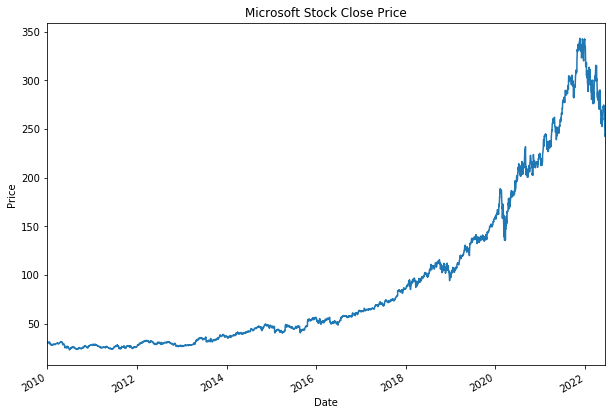

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

data = yf.download('MSFT', '2010-01-01')
data['Close'].plot(figsize=(10,7))
plt.title('Microsoft Stock Close Price')
plt.ylabel('Price')
plt.show()

In [11]:
data.head

<bound method NDFrame.head of                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2009-12-31   30.980000   30.990000   30.480000   30.480000   23.438799   
2010-01-04   30.620001   31.100000   30.590000   30.950001   23.800217   
2010-01-05   30.850000   31.100000   30.639999   30.959999   23.807911   
2010-01-06   30.879999   31.080000   30.520000   30.770000   23.661804   
2010-01-07   30.629999   30.700001   30.190001   30.450001   23.415735   
2010-01-08   30.280001   30.879999   30.240000   30.660000   23.577213   
2010-01-11   30.709999   30.760000   30.120001   30.270000   23.277309   
2010-01-12   30.150000   30.400000   29.910000   30.070000   23.123507   
2010-01-13   30.260000   30.520000   30.010000   30.350000   23.338825   
2010-01-14   30.309999   31.100000   30.260000   30.959999   23.807911   
2010-01-15   31.080000   31.240000   30.709999   30.860001   23.731016   
2010-01-

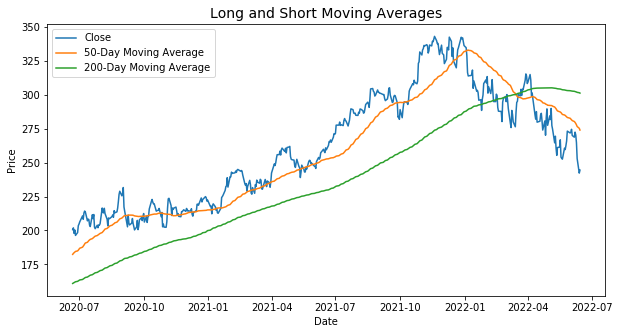

In [3]:
# Define long and short window 
short_window = 50
long_window = 200

# Calculate moving averages
data['short_mavg'] = data['Close'].rolling(short_window).mean()
data['long_mavg'] = data['Close'].rolling(long_window).mean()

# Plot close price and moving averages
plot_data = data[-500:]
plt.figure(figsize=(10, 5))
plt.title('Long and Short Moving Averages', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price')

plt.plot(plot_data['Close'], label='Close')
plt.plot(plot_data['short_mavg'], label='50-Day Moving Average')
plt.plot(plot_data['long_mavg'], label='200-Day Moving Average')

plt.legend()

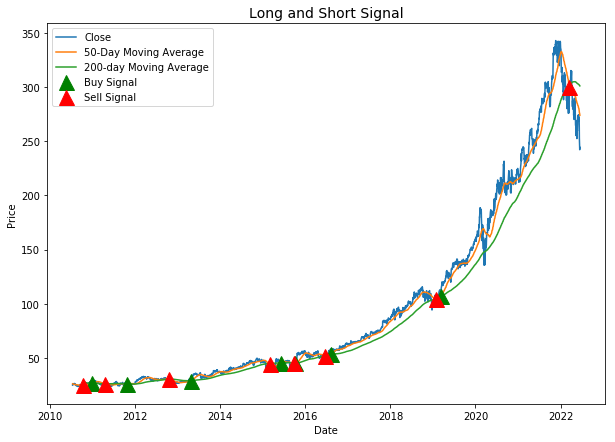

In [4]:
# Take long positions
data['long_positions'] = np.where(data['short_mavg'] > data['long_mavg'], 1, 0)

# Take short positions
data['short_positions'] = np.where(data['short_mavg'] < data['long_mavg'], -1, 0)

data['positions'] = data['long_positions'] + data['short_positions'] 

# Plot close price and moving averages
plot_data = data[-3000:]
plt.figure(figsize=(10, 7))
plt.title('Long and Short Signal', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price')

plt.plot(plot_data['Close'], label='Close')
plt.plot(plot_data['short_mavg'], label='50-Day Moving Average')
plt.plot(plot_data['long_mavg'], label='200-day Moving Average')


plt.plot(plot_data[(plot_data['long_positions'] == 1) &
                       (plot_data['long_positions'].shift(1) == 0)]['short_mavg'],
         '^', ms=15, label='Buy Signal', color='green')


plt.plot(plot_data[(plot_data['short_positions'] == -1) &
                       (plot_data['short_positions'].shift(1) == 0)]['short_mavg'],
         '^', ms=15, label='Sell Signal', color='red')

plt.legend()
plt.show()

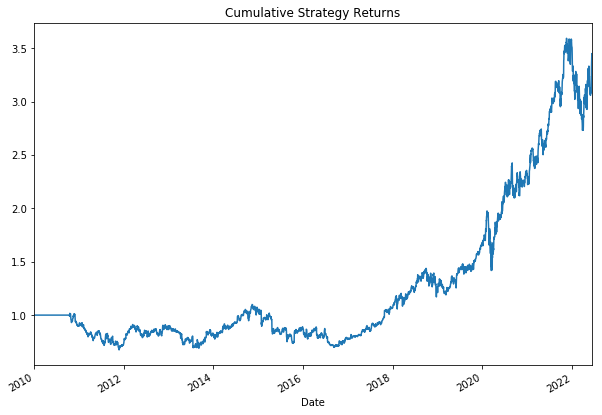

In [5]:
# Calculate daily returns
data['returns'] = data['Close'].pct_change()

# Calculate strategy returns
data['strategy_returns'] = data['returns'] * data['positions'].shift(1)

# Plot cumulative returns
cumulative_returns = (data['strategy_returns'] + 1).cumprod()
cumulative_returns.plot(figsize=(10, 7))
plt.title('Cumulative Strategy Returns')
plt.show()

In [6]:
# Total number of trading days
days = len(cumulative_returns)

# Calculate compounded annual growth rate
# We will use 252 instead oof 365, as number of trading days in a year is 252
annualised_returns = (cumulative_returns.iloc[-1]**(252/days)-1)*100


In [7]:
# Calculate annualised volatility
annualised_volatility = np.std(data.strategy_returns)*(252**0.5)*100

In [8]:
# Assume an average annual risk-free rate is 1%
risk_free_rate = 0.01/252

sharpe_ratio = np.sqrt(252)*(np.mean(data.strategy_returns) -
                       (risk_free_rate))/np.std(data.strategy_returns)

In [9]:
# Calculate the running maximum
running_max = np.maximum.accumulate(cumulative_returns.dropna())

# Ensure the value never drops below 1
running_max[running_max < 1] = 1

# Calculate the percentage drawdown
drawdown = (cumulative_returns)/running_max - 1
max_dd = drawdown.min()*100

print('The annualised retunrs of strategy is %.2f' % annualised_returns + '%')

The annualised retunrs of strategy is 10.38%


In [13]:
import numpy as np
import pandas as pd
import requests
from sklearn.linear_model import BayesianRidge

#load market data
data = yf.download('MSFT', '2010-01-01')

#shift target variable one day back 
#in order to train model to predict one day into future
data['close_shifted'] = data['close'].shift(-1)
data = data.dropna()

#make numpy arrays
x = np.array(data[['close', 'high', 'low', 'open']])
y = np.array(data['close_shifted']).reshape(-1,1)

#custom backtest function
def backtest(n_days):
    """
    n_days - amount of the last n_days that we whant to get prediction and calculate metrics
    """
    predictions = []
    true_values = []
    for i in reversed(range(1, n_days)):
        x_train = x[:len(x)-i]
        y_train = y[:len(y)-i]
        x_test = x[len(x)-i]
        y_test = y[len(y)-i]
        model = BayesianRidge()
        model.fit(x_train, y_train)
        predictions.append(model.predict([x_test])[0])
        true_values.append(y_test[0])
    return true_values, predictions
 
true_values, predictions = backtest(20)

[*********************100%***********************]  1 of 1 completed


KeyError: 'close'